<a href="https://colab.research.google.com/github/bongminyoon/bong/blob/main/240328.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

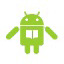

In [6]:
from google.colab.patches import cv2_imshow
import cv2
import os

# 이미지 파일 경로
image_path = '/content/robot2.jpg'

# 이미지 불러오기
# Check if the file exists before trying to read it
if os.path.exists(image_path):
    image = cv2.imread(image_path)
else:
    print(f"Error: Image file not found at {image_path}")
    # Handle the error appropriately, e.g., exit the program or use a default image

# If image loaded successfully, proceed with the rest of the code
if image is not None:
    # 얼굴 검출을 위한 Haar Cascade 분류기 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 얼굴 검출
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # 검출된 얼굴 주변에 사각형 그리기
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 결과 이미지 출력
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Could not load image. Exiting program.")